In [13]:
import pandas as pd
import seaborn as sns
import os
from IPython.display import Image

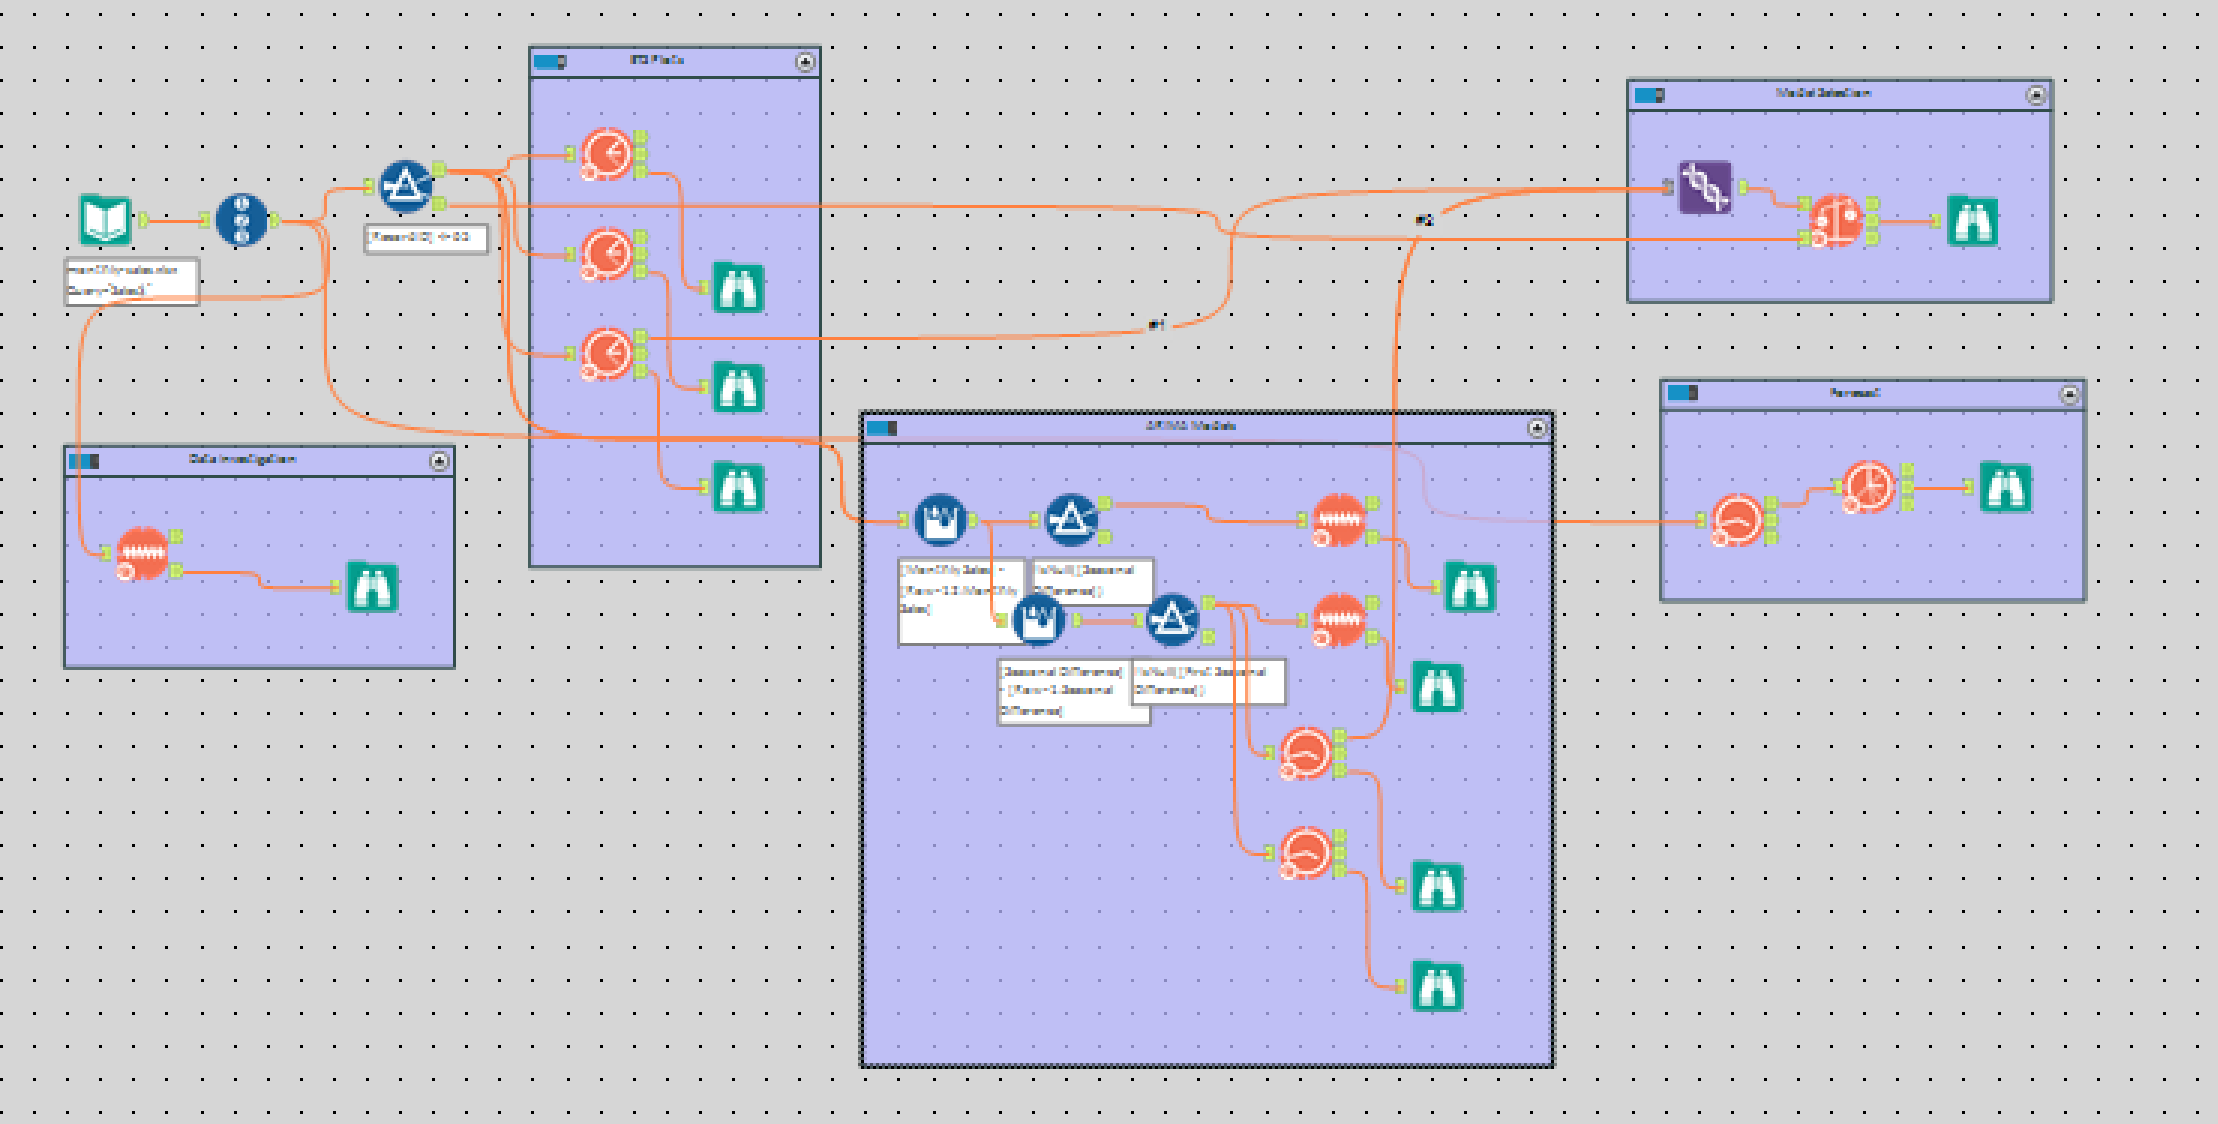

In [14]:
Image(os.listdir()[2])

In [4]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'alteryx_workflow_time_series_notebook.PNG',
 'main.py',
 'monthly-sales.xlsx',
 'Notebook.ipynb',
 'README.md']

In [7]:
data = pd.read_excel(os.listdir()[4])

In [8]:
data.head()

,Month,Monthly Sales
0,2008-01,154000
1,2008-02,96000
2,2008-03,73000
3,2008-04,51000
4,2008-05,53000


In [9]:
data['Month'] = pd.to_datetime(data['Month'])

In [10]:
data.head()

,Month,Monthly Sales
0,2008-01-01,154000
1,2008-02-01,96000
2,2008-03-01,73000
3,2008-04-01,51000
4,2008-05-01,53000


In [11]:
data.dtypes

Month            datetime64[ns]
Monthly Sales             int64
dtype: object

In [15]:
data.set_index(data['Month'], drop = True, inplace = True)

In [16]:
data.head()

,Month,Monthly Sales
Month,,
2008-01-01,2008-01-01,154000
2008-02-01,2008-02-01,96000
2008-03-01,2008-03-01,73000
2008-04-01,2008-04-01,51000
2008-05-01,2008-05-01,53000


In [17]:
data.drop(columns = ['Month'], inplace = True)

In [18]:
data.head()

,Monthly Sales
Month,
2008-01-01,154000
2008-02-01,96000
2008-03-01,73000
2008-04-01,51000
2008-05-01,53000
